<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 8: OpenStreetMap, OSMnx & pyrosm </h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Ane Rahbek Vierø</h3>
</div>

This notebook was adapted from:
* OSMnx examples: https://github.com/gboeing/osmnx-examples
* pyrosm examples: https://pyrosm.readthedocs.io/en/latest/basics.html#read-street-networks

In [1]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd
import pyrosm
import matplotlib.pyplot as plt
import contextily as cx 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

'1.2.3'

# 1. OSMnx overview: Querying & plotting

OSMnx is a great library for downloading and working with OSM data. The 'nx' in OSMnx comes from [NetworkX](https://networkx.org/documentation/stable/index.html) and tells us that OSMnx is especially great for accessing and analyzing street network data.
For very large data sets, pyrosm is a better choice (more on that below).

## OSMnx settings

You can configure OSMnx `ox.settings` See the [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=settings#module-osmnx.settings) for the settings you can configure. For example, by default OSMnx caches all server responses to prevent repeatedly hitting the server for the same query every time you run it. This both makes our code faster on subsequent runs and helps us be a "good user". But you can turn caching off (or back on again) with the `use_cache` parameter. Any parameters not passed to the config function are (re-)set to their original default values whenever you call it. If you are re-loading data for an analysis over a long time period, it can be a good idea to turn cacheing of, to avoid getting old outdated data.


In [2]:
# turn response caching off
ox.settings.use_cache=False  # If you are working on a project where you often re-download data, turning it off is recommended!

# turn it back on and turn on/off logging to your console
ox.settings.use_cache=True
ox.settings.log_console=False

## 1.1: Get place boundaries from OpenStreetMap

OSMnx lets you download place boundary geometries from OpenStreetMap, project them*, and plot them. For a more in-depth demonstration of querying by place, see [this notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/03-graph-place-queries.ipynb).

*If no crs is provided, OSMnx will use the default UTM zone for the location of the data, so use this with care!

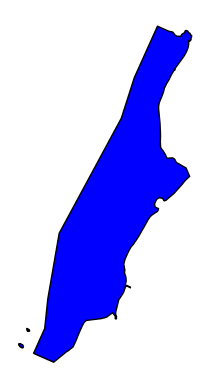

In [3]:
# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocode_to_gdf("Manhattan")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="blue", ec="black")
ax.axis("off");

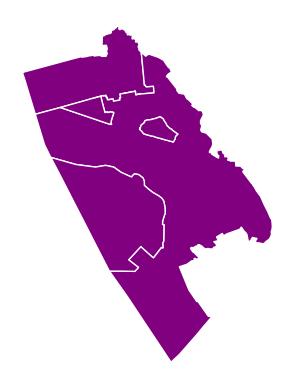

In [4]:
# get boundary polygons for several cities, save as GeoPackage, project to UTM, and plot
place_names = [
    "Berkeley, California, USA",
    "Oakland, California, USA",
    "Piedmont, California, USA",
    "Emeryville, California, USA",
    "Alameda, Alameda County, CA, USA",
]
east_bay = ox.geocode_to_gdf(place_names)
east_bay.to_file("data/east_bay.gpkg", driver="GPKG")
east_bay = ox.project_gdf(east_bay)
ax = east_bay.plot(fc="purple", ec="white")
ax.axis("off");

## 1.2: Download building footprints & POIs

To download data from OSM with OSMnx *other* than the street network, we use `ox.geomtries_from_place`/`ox.geomtries_from_point`/`ox.geomtries_from_polygon` and pass a dictionary with tags and tag values used to query the Overpass API (see next section for examples of the difference between using '_place', '_point' or '_polygon')

If we use "True" as the tag value, all objects in the area with some value for that tag will be downloaded.

### Building footprints

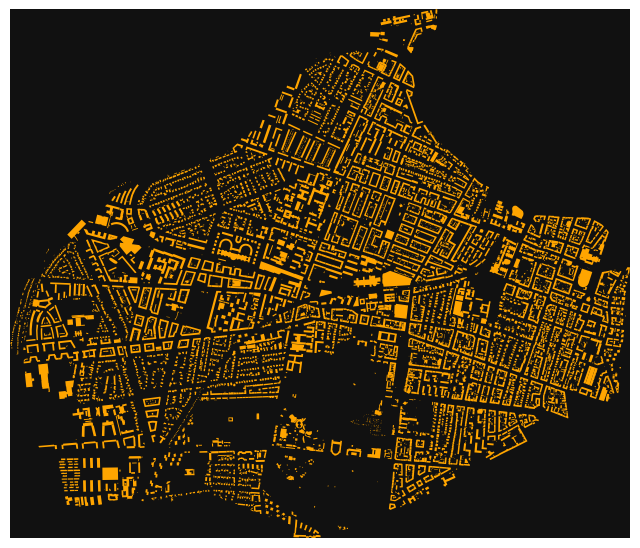

In [5]:
gdf = ox.geometries_from_place("Frederiksberg Municipality", tags = {"building": True})
gdf_proj = ox.project_gdf(gdf, to_crs="EPSG:25832")
fig, ax = ox.plot_footprints(gdf_proj, filepath="files/frb_buildings.png", dpi=400, save=True, show=True, close=True)

**Note** that these methods will return *all* objects regardless of their geometry type. For Frederiksberg, we for example also get buildings with a point geometry:

In [6]:
gdf_proj.geom_type.unique()

array(['Point', 'Polygon', 'MultiPolygon'], dtype=object)

### POIs

POIs, or 'points of interest' are for example shops, restaurants, schools, public transport, etc.
Note that OSM sometimes isn't *as* complete as e.g. Google Maps for POIs in all locations.

To get all bakeries in Cph + Frederiksberg, we look for all objects with the tag combination "shop:bakery":

In [7]:
tags = {"shop": "bakery"}
bakeries = ox.geometries_from_place(["Copenhagen Municipality", "Frederiksberg Municipality"], tags)

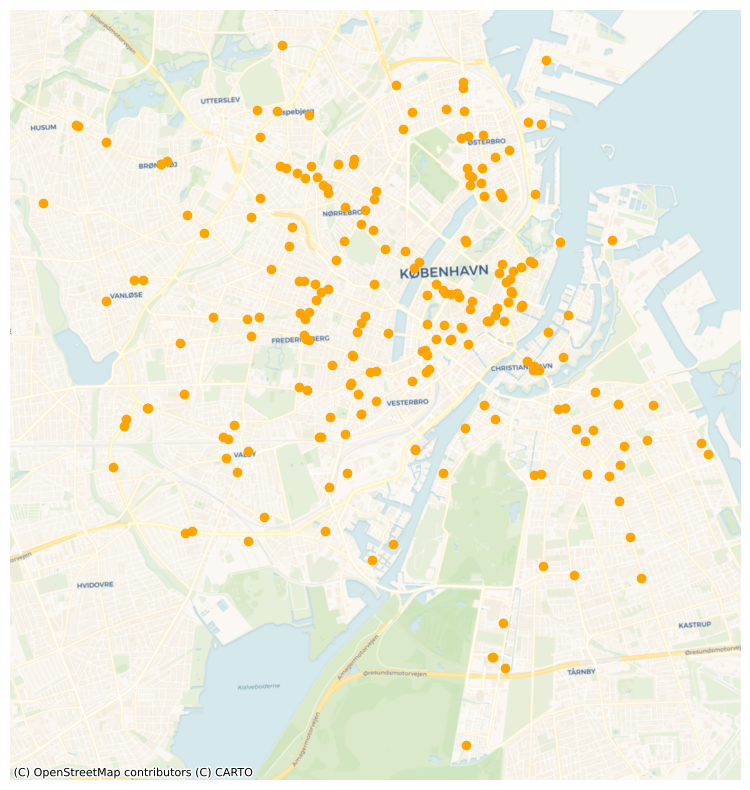

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

bakeries.to_crs("EPSG:25832").plot(ax=ax, color='orange')
ax.set_axis_off()
cx.add_basemap(
    ax=ax, 
    crs="EPSG:25832", 
    source=cx.providers.CartoDB.Voyager);

## Part 1.3: Download street networks

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network for later use. The street networks are directed and preserve one-way directionality.

You can download a street network by providing OSMnx any of the following (some are demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries
  - a .osm formatted xml file

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones

 #### Method #1: Pass a bounding box

This constructs the network from all the OSM nodes and ways within the bounding box.

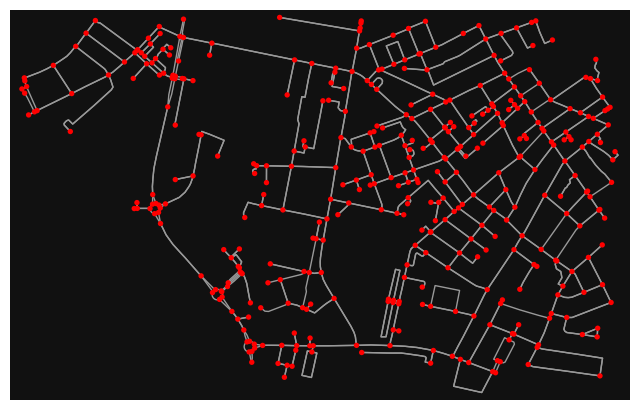

In [9]:
# define a bounding box around ITU
north, south, east, west = 55.6646, 55.6540, 12.5767, 12.6077 # lat lon coordinates!

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
ox.plot_graph(G, node_color="r");

#### Method #2: Pass a lat-lng point and bounding box distance in meters

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

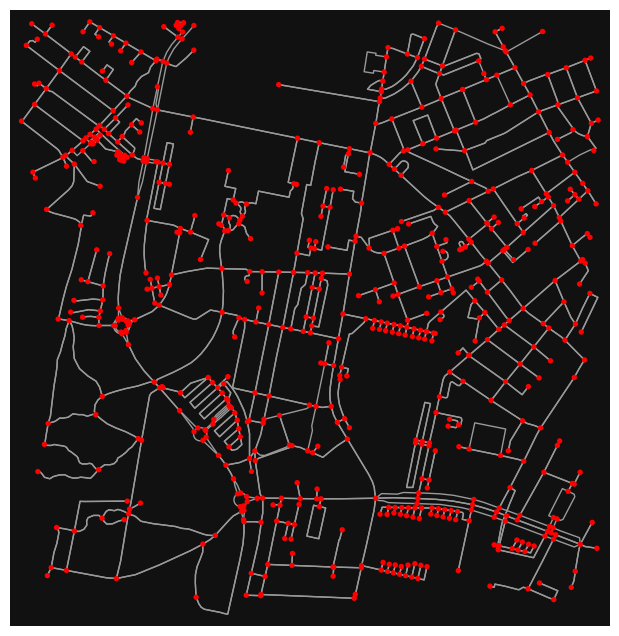

In [10]:
# define a point at ITU
location_point = (55.659323, 12.591472)

# create bikeable network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="bike")
ox.plot_graph(G, node_color="r");

#### Method #3: Pass a lat-lng point and *network* distance in meters ####

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it truncates the network by removing all nodes further than *n* meters from the point along the network.

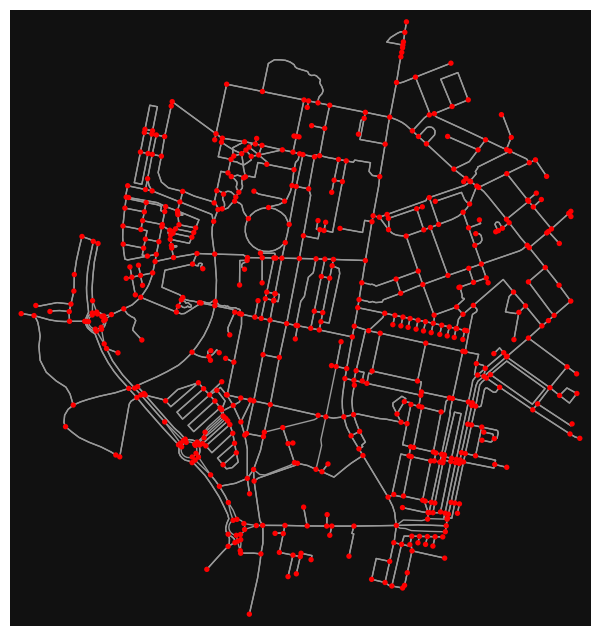

In [11]:
# same point again, but create network only of nodes within 750m along the network from point
G1 = ox.graph_from_point(location_point, dist=750, dist_type="network")
ox.plot_graph(G1, node_color="r");

**Note** the plot above shows the network within 750m (traveling distance along the network) from the `location_point`. By default, the `network_type` parameter value is 'all', meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 750m takes into account only those nodes you can reach within 750m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. Thus, the 750m now takes into account those nodes you can reach within 750m while traveling in either direction (even if it's a one-way street).

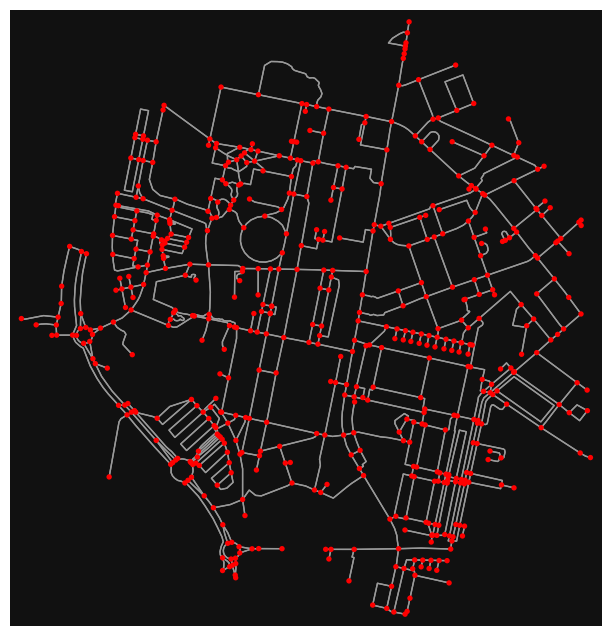

In [12]:
# create network only of nodes within 750m walking along the network from point
G2 = ox.graph_from_point(location_point, dist=750, dist_type="network", network_type="walk")
ox.plot_graph(G2, node_color="r");

#### Method #4: Pass an address and distance (*bounding box* or *network*) in meters

This geocodes* the address, creates a bounding box, downloads the network, then truncates it by network distance (if distance_type='network').

*Geocoding is the process of converting addresses to coordinates. Geocoding based on OSM data is usually done with [Nominatim](https://nominatim.org/).

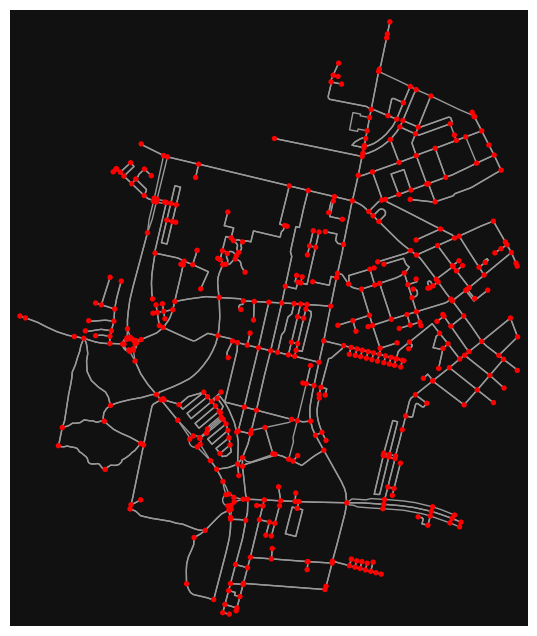

In [13]:
# network from address, including only nodes within 1km along the network from the address
G = ox.graph_from_address(
    address="7 Rued Langgaards Vej, Copenhagen",
    dist=1000,
    dist_type="network",
    network_type="bike",
)

# you can project the network to UTM (zone calculated automatically)
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected, node_color="r");


#### Method #5: Pass a place name ####

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then truncates it to the place's boundary polygon.

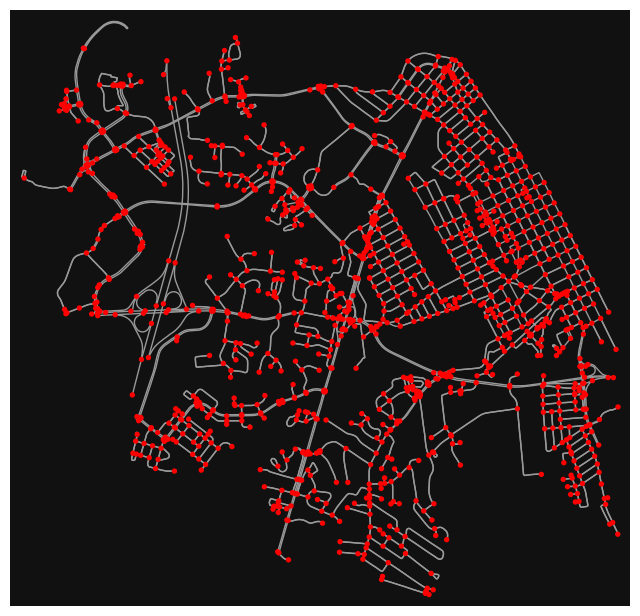

In [14]:
G = ox.graph_from_place("Frederiksberg", network_type="drive")
ox.plot_graph(G, node_color="r");

This is not the Frederiksberg we were looking for! It is Fredericksburg in Virginia. What happened? Names are resolved via nominatim, which returns the first result that is a polygon or multipolygon. All results are listed here: https://nominatim.openstreetmap.org/ui/search.html?q=Frederiksberg

So where is the Frederiksberg we are looking for?

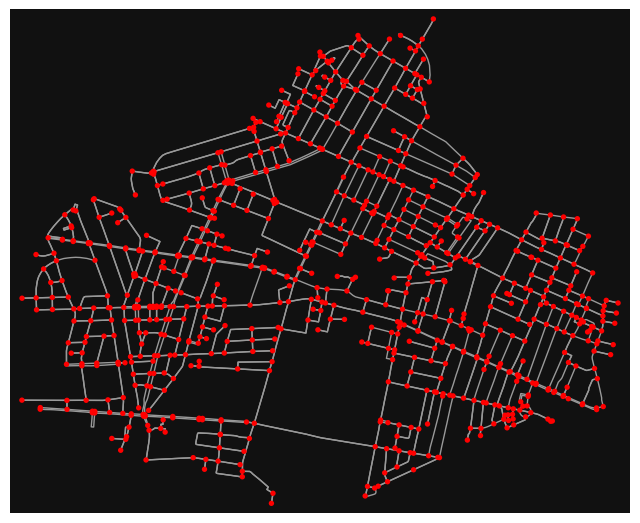

In [15]:
# Frederiksberg Municipality, Denmark
G_fred = ox.graph_from_place("Frederiksberg Municipality", network_type="drive")
G_fred = ox.project_graph(G_fred)
ox.plot_graph(G_fred, node_color="r");

In [16]:
G_fred

Be aware that this is a MultiDiGraph, i.e. a multigraph (parallel edges are possible), which is directed. Because there can be multiple links between a pair of nodes, each link is identified with a triple: (node1id, node2id, counter) (a multiindex):

In [17]:
list(G_fred.edges)[:10]

[(576734, 576735, 0),
 (576734, 281882807, 0),
 (576734, 282822735, 0),
 (576734, 929287662, 0),
 (576735, 576734, 0),
 (576735, 2955858500, 0),
 (576735, 282823010, 0),
 (281882807, 576734, 0),
 (281882807, 281882851, 0),
 (281882807, 792862, 0)]

In OSMnx, node1 is called `u`, node2 is called `v` and the counter is `k`, which we can see if we convert our graph to geodataframes:

In [18]:
nodes, edges = ox.graph_to_gdfs(G_fred)
edges.head()

osmid lanes             name   highway  \
u      v         key                                                          
576734 576735    0    [113540480, 1700501]     2  Nordre Fasanvej  tertiary   
       281882807 0                 1701842   NaN       Smallegade  tertiary   
       282822735 0                26176314   NaN  Peter Bangs Vej  tertiary   
       929287662 0                43633664     2  Søndre Fasanvej  tertiary   
576735 576734    0    [113540480, 1700501]     2  Nordre Fasanvej  tertiary   

                     maxspeed  oneway reversed   length  \
u      v         key                                      
576734 576735    0         50   False    False  154.328   
       281882807 0         50   False    False  154.686   
       282822735 0         50   False    False   56.842   
       929287662 0         50   False    False  187.705   
576735 576734    0         50   False     True  154.328   

                                                               geometry  \
u      v         key                                                      
576734 576735    0    LINESTRING (344153.256 6173178.645, 344158.093...   
       281882807 0    LINESTRING (344153.256 6173178.645, 344156.842...   
       282822735 0    LINESTRING (344153.256 6173178.645, 344140.724...   
       929287662 0    LINESTRING (344153.256 6173178.645, 344150.880...   
576735 576734    0    LINESTRING (344198.806 6173326.209, 344189.703...   

                     junction tunnel width bridge access  
u      v         key                                      
576734 576735    0        NaN    NaN   NaN    NaN    NaN  
       281882807 0        NaN    NaN   NaN    NaN    NaN  
       282822735 0        NaN    NaN   NaN    NaN    NaN  
       929287662 0        NaN    NaN   NaN    NaN    NaN  
576735 576734    0        NaN    NaN   NaN    NaN    NaN

Beware of weird or unexpected administrative regions, so always double-check your results:

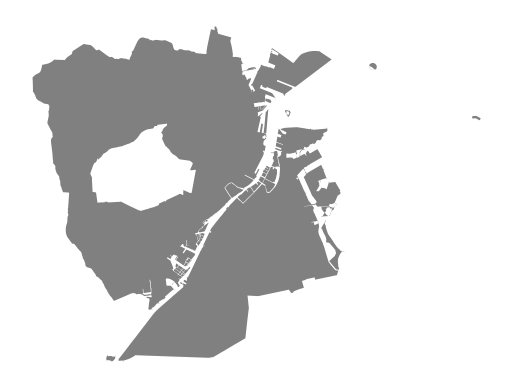

In [19]:
# get the boundary polygon for Copenhagen, project it, and plot it
city = ox.geocode_to_gdf("Copenhagen Municipality")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
ax.axis("off");

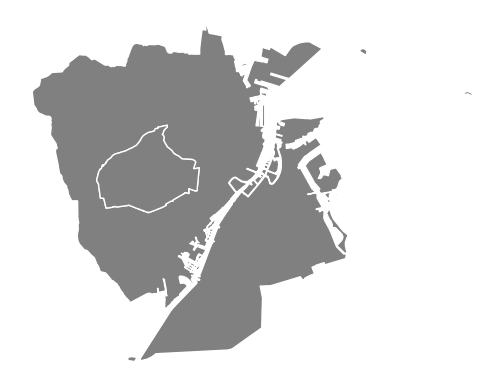

In [20]:
# get the boundary polygon for Copenhagen including Frederiksberg, project it, and plot it
city = ox.geocode_to_gdf(["Copenhagen Municipality", "Frederiksberg Municipality"])
city_proj = ox.project_gdf(city, to_crs="EPSG:25832")
ax = city_proj.plot(fc="gray", ec="white")
ax.axis("off");

You can see a thin boundary around Frederiksberg because the two municipalities still are defined by each their separate geometry. If you wanted to use the shapes further, for example as a boundary to select further objects, you could dissolve the polygons with shapely:

In [21]:
city_proj

geometry  bbox_north  bbox_south  \
0  MULTIPOLYGON (((716905.648 6179453.885, 716912...   55.732703   55.612861   
1  POLYGON ((719497.114 6175889.311, 719585.925 6...   55.697681   55.666502   

   bbox_east  bbox_west   place_id  osm_type   osm_id        lat        lon  \
0  12.734246  12.453000  346634599  relation  2192363  55.655547  12.601643   
1  12.557342  12.491315  298300852  relation  2186660  55.681939  12.523431   

                                        display_name     class  \
0  Copenhagen Municipality, Capital Region of Den...  boundary   
1  Frederiksberg Municipality, Capital Region of ...  boundary   

             type  importance  
0  administrative    0.695253  
1  administrative    0.677530

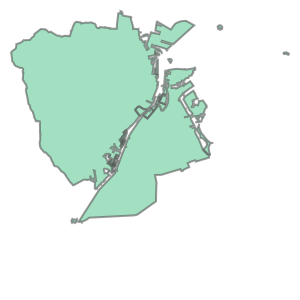

In [22]:
from shapely.ops import unary_union
unary_union([p for p in city_proj.geometry])

# 2. Working with street networks

## 2.1 Simplifying street network topology

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. 

OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows nodes even if they aren't end points or intersections but have incident edges with different OSM ID.

Note that the simplification routine only considers network topology! If edges with differing tag values are merged in the simplification process, the tag value is a list of all the different tag values in the original edges (e.g. highway = ['primary','secondary']).

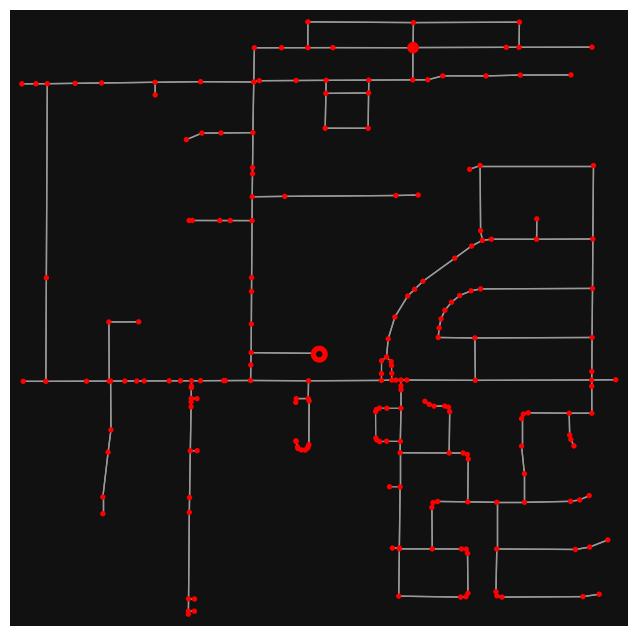

In [23]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type="drive_service", dist=500, simplify=False)
ox.plot_graph(G, node_color="r");

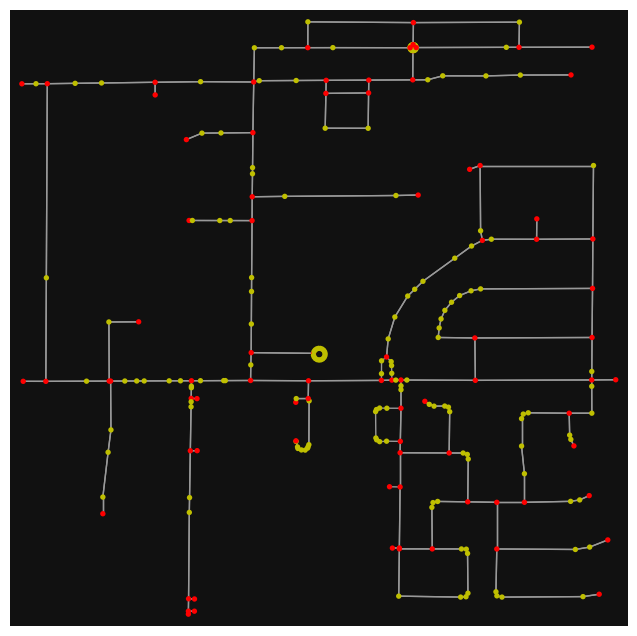

In [24]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc);

The dots above are OSM nodes. We'll remove the nodes in yellow as they're not real network nodes (intersections/dead-ends).

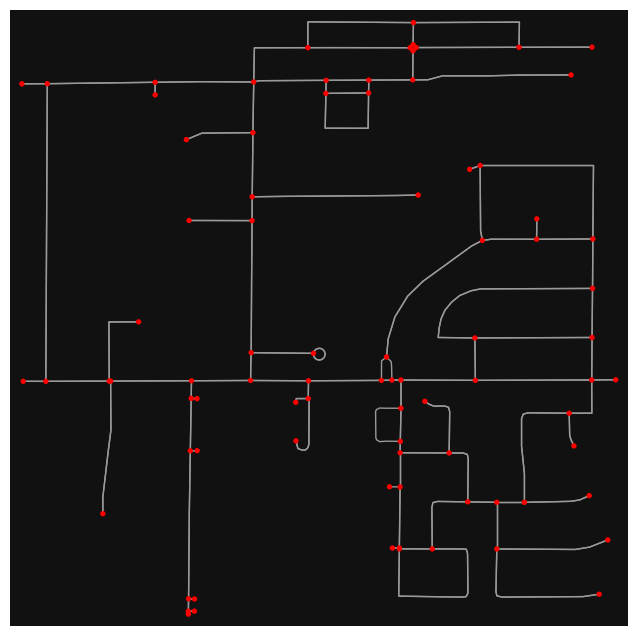

In [25]:
# simplify the network
G = ox.simplify_graph(G)
ox.plot_graph(G, node_color="r");

## 2.2 Consolidating network intersections

Complex intersection consolidation

Many real-world street networks feature complex intersections and traffic circles, resulting in a cluster of graph nodes where there is really just one true intersection, as we would think of it in transportation or urban design. Similarly, divided roads are often represented by separate centerline edges: the intersection of two divided roads thus creates 4 nodes, representing where each edge intersects a perpendicular edge, but these 4 nodes represent a single intersection in the real world. Traffic circles similarly create a cluster of nodes where each street's edge intersects the roundabout.

OSMnx can consolidate nearby intersections and optionally rebuild the graph's topology.

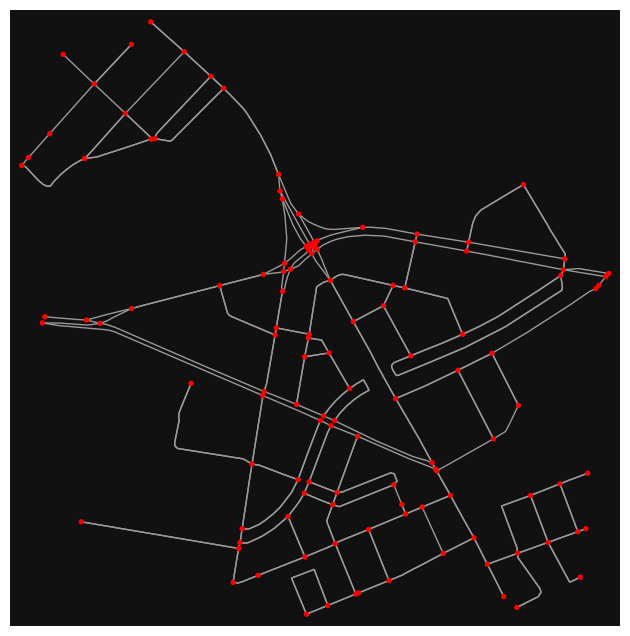

In [26]:
# get a street network and plot it with all edge intersections
point = 55.667708, 12.596266
G = ox.graph_from_point(point, network_type="drive", dist=500)
ox.plot_graph(G, node_color="r");

Notice the complex intersections creating clusters of nodes.

We'll specify that any nodes with 15 meter buffers of each other in this network are part of the same intersection. Adjust this tolerance based on the street design standards in the community you are examining, and use a projected graph to work in meaningful units like meters. We'll also specify that we do not want dead-ends returned in our list of consolidated intersections.

In [27]:
# get a GeoSeries of consolidated intersections
G_proj = ox.project_graph(G)
intersections = ox.consolidate_intersections(
    G_proj, 
    rebuild_graph=False, # wheb rebuild is set to False, the function only returns the consolidated intersections
    tolerance=15, 
    dead_ends=False
)
len(intersections)

73

In [28]:
# compare to number of nodes in original graph
len(G)

122

Note that these cleaned up intersections give us more accurate intersection counts and densities, but do not alter or integrate with the network's topology.

To do that, we need to **rebuild the graph**.

In [29]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.consolidate_intersections(G_proj, 
                                  rebuild_graph=True, 
                                  tolerance=15, 
                                  dead_ends=False)
len(G2)

76

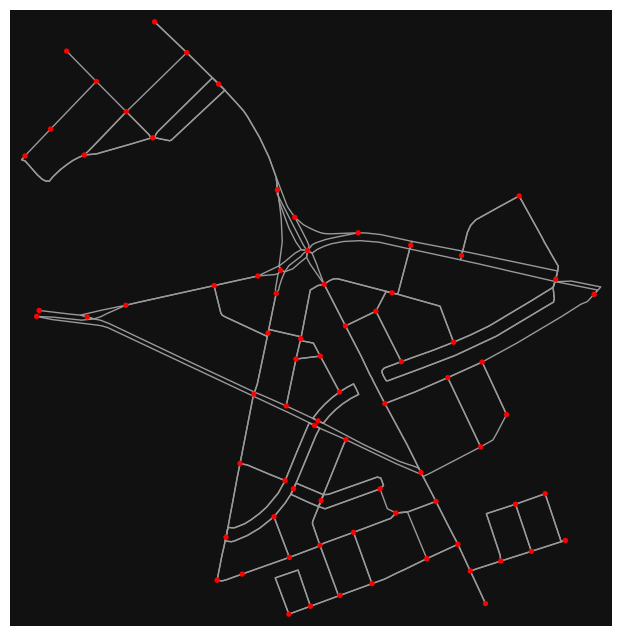

In [30]:
fig, ax = ox.plot_graph(G2, node_color="r")

Notice how the traffic circles' many nodes are merged into a new single centroid node, with edge geometries extended to connect to it. Similar consolidation occurs at the intersection of the divided roads.

Running `consolidate_intersections` with `rebuild_graph=True` may yield somewhat (but not very) different intersection counts/densities compared to `rebuild_graph=False`. The difference lies in that the latter just merges buffered node points that overlap, whereas the former checks the topology of the overlapping node buffers before merging them.

This prevents topologically remote but spatially proximate nodes from being merged. For example:

  - A street intersection may lie directly below a freeway overpass's intersection with an on-ramp. We would not want to merge these together and connnect their edges: they are distinct junctions in the system of roads.
  - In a residential neighborhood, a bollarded street may create a dead-end immediately next to an intersection or traffic circle. We would not want to merge this dead-end with the intersection and connect their edges.

These examples illustrate (two-dimensional) geometric proximity, but topological remoteness. Accordingly, in some situations we may expect higher intersection counts when using `rebuild_graph=True` because it is more cautious with merging in these cases. The trade-off is that it has higher time complexity than `rebuild_graph=False`.

## 2.3 Cleaning up the periphery of the network

This step is related to the network simplification. OSMnx by default (with clean_periphery parameter equal to True) buffers the area you request by 0.5km, and then retrieves the street network within this larger, buffered area. Then it simplifies the topology so that nodes represent intersections of streets (rather than including all the interstitial OSM nodes). Then it calculates the (undirected) degree of each node in this larger network. Next it truncates this network by the actual area you requested (either by bounding box, or by polygon). Finally it saves a dictionary of node degree values as a graph attribute.

This has two primary benefits. First, it cleans up stray false edges around the periphery. If clean_periphery=False, peripheral non-intersection nodes within the requested area appear to be cul-de-sacs, as the rest of the edge leading to an intersection outside the area is ignored. If clean_periphery=True, the larger graph is first created, allowing simplification of such edges to their true intersections, allowing their entirety to be pruned after truncating down to the actual requested area. Second, it gives accurate node degrees by both a) counting node neighbors even if they fall outside the retained network (so you don't claim a degree-4 node is degree-2 because only 2 of its neighbors lie within the area), and b) not counting all those stray false edges' terminus nodes as cul-de-sacs that otherwise grossly inflate the count of nodes with degree=1, even though these nodes are really just interstitial nodes in the middle of a chopped-off street segment between intersections.

See two examples below.

In [31]:
# get some bbox
bbox = ox.utils_geo.bbox_from_point((45.518698, -122.679964), dist=300)
north, south, east, west = bbox

/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/osmnx/graph.py:488: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  warnings.warn(msg)


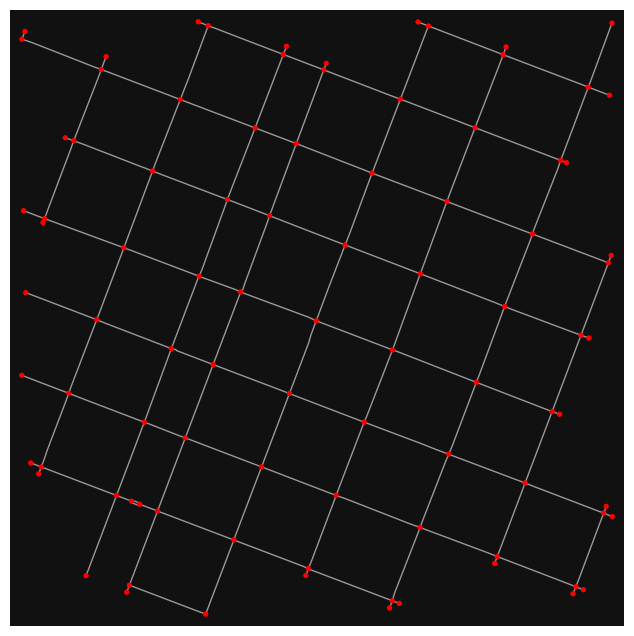

In [32]:
G = ox.graph_from_bbox(north, south, east, west, network_type="drive", clean_periphery=False)
ox.plot_graph(G, node_color="r");

In [33]:
# the node degree distribution for this graph has many false cul-de-sacs
k = dict(G.degree())
{n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 30, 2: 2, 3: 6, 4: 52}

Above, notice all the peripheral stray edge stubs. Below, notice these are cleaned up and that the node degrees are accurate with regards to the wider street network that may extend beyond the limits of the requested area.

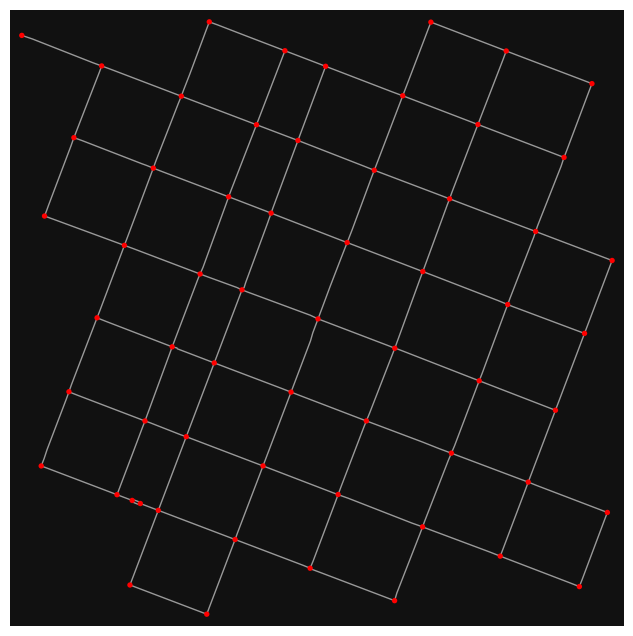

In [34]:
G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
ox.plot_graph(G, node_color="r");

In [35]:
# the streets per node distribution for this cleaned up graph is more accurate
# dict keys = count of streets emanating from the node (ie, intersections and dead-ends)
# dict vals = number of nodes with that count
k = nx.get_node_attributes(G, "street_count")
{n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 0, 2: 0, 3: 3, 4: 57}

## 2.4 Highlighting network properties

OSMnx can also highlight different edge attributes. To read more about how edge attributes are stored and accessed, see https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html

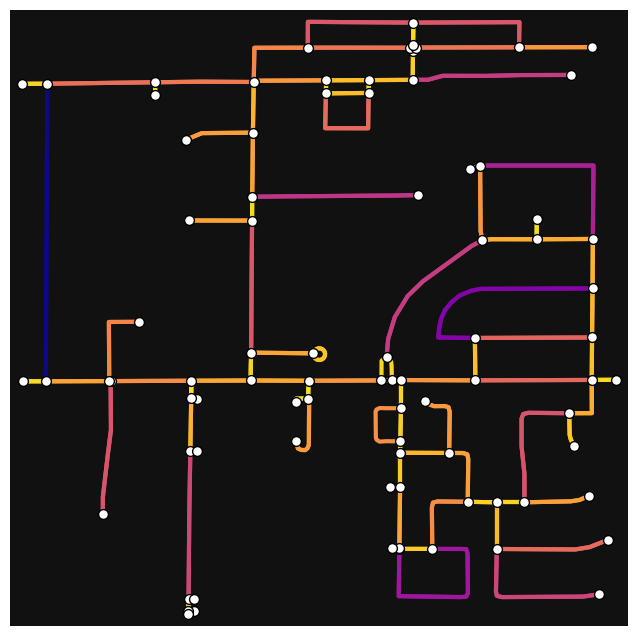

In [36]:
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type="drive_service", dist=500, simplify=False)
G = ox.simplify_graph(G)

# show the simplified network with edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap="plasma_r")
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

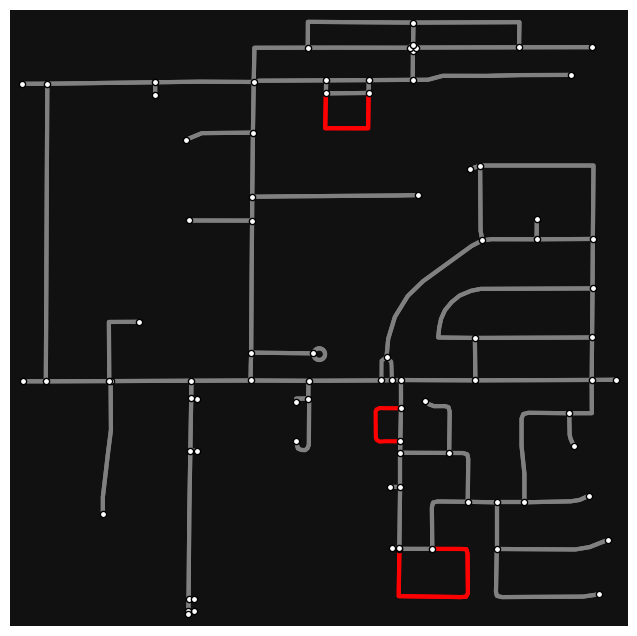

In [37]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=20, edge_color=ec, edge_linewidth=3
)

**We can see the parallel edges in the data (edges with identical values for start and end nodes):**

In [38]:
list(G.edges)[:10]

[(41542771, 41542772, 0),
 (41542771, 41542772, 1),
 (41542771, 7655352447, 0),
 (41542772, 41542771, 0),
 (41542772, 41542771, 1),
 (41542772, 42238826, 0),
 (41542778, 41612013, 0),
 (41542778, 371845086, 0),
 (41542778, 42449935, 0),
 (41544344, 41756544, 0)]

**To see the data for a specific edge, use the ids of the edge's start node, end node and counter:**

In [39]:
G_fred.edges[576734, 576735, 0]

{'osmid': [113540480, 1700501],
 'lanes': '2',
 'name': 'Nordre Fasanvej',
 'highway': 'tertiary',
 'maxspeed': '50',
 'oneway': False,
 'reversed': False,
 'length': 154.328,
 'geometry': <shapely.geometry.linestring.LineString at 0x195b10220>}

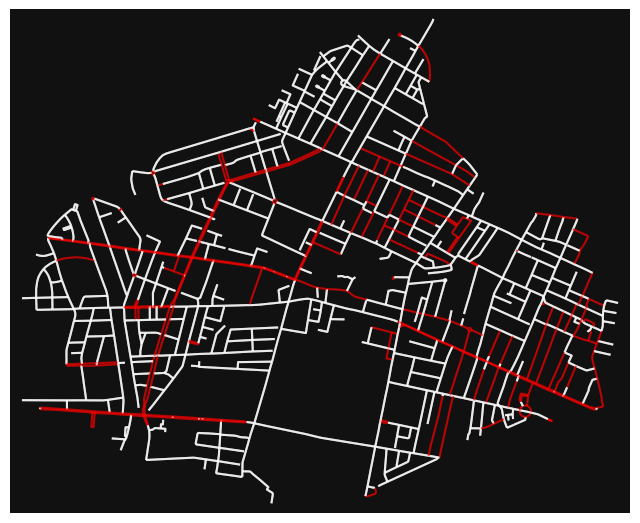

In [40]:
# highlight all one-way edges in the Frederiksberg network from earlier
ec = ["r" if data["oneway"] else "w" for u, v, key, data in G_fred.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G_fred, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

Be aware that streets made up of two (minimally separated) lanes could have their lanes marked as "oneway", but effectively the street is twoway! For example, Roskildevej on the bottom left of the map:

<img src="files/roskildevej.jpg">

## 2.5 Routing, speed imputation & travel times

Calculating lots of shortest paths can be slow, but OSMnx has built-in shortest path solver parallelization and multiprocessing, see: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/02-routing-speed-time.ipynb.

igraph can be used as a much faster alternative for larger street networks: https://igraph.org/python/

### Fast nearest node/edge search with OSMnx

The nearest_nodes and nearest_edges functions take arrays of x and y (or lng/lat) coordinates and return the nearest node/edge to each.

In [41]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(G_fred), n=30)
X = points.x.values
Y = points.y.values

**Find each nearest node to several points, and optionally return distance:**

In [42]:
nodes, dists = ox.nearest_nodes(G_fred, X, Y, return_dist=True)
(nodes[:4],dists[:4])

([726145, 280205151, 793268, 281884747],
 [12.466481823868133, 137.07483497281706, 25.48293664200578, 4.48084508962993])

**Find the nearest node to a single point:**

In [43]:
node = ox.nearest_nodes(G_fred, X[0], Y[0])
node

726145

**Find each nearest edge to several points, and optionally return distance:**

In [44]:
edges, dists = ox.nearest_edges(G_fred, X, Y, return_dist=True)
(edges[:4],dists[:4])

([(726094, 726145, 0),
  (20974557, 280205151, 0),
  (793268, 793267, 0),
  (726544, 281884747, 0)],
 [3.5423898999439437e-12,
  9.16320701157065e-11,
  7.538465875284449e-11,
  2.9981236643312477e-12])

**Find the nearest edge to a single point:**

In [45]:
edge = ox.nearest_edges(G_fred, X[0], Y[0])
edge

(726094, 726145, 0)

### Basic routing by distance

Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

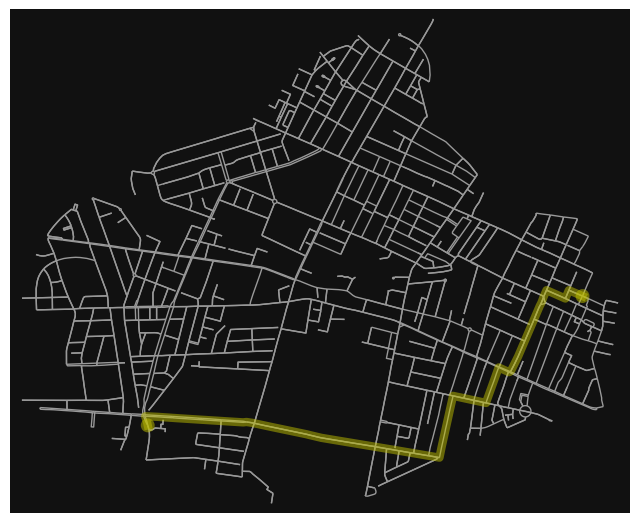

In [46]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G_fred)[41]
dest = list(G_fred)[220]
route = ox.shortest_path(G_fred, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G_fred, route, route_color="y", route_linewidth=6, node_size=0)

Or get *k* shortest paths, weighted by some attribute:

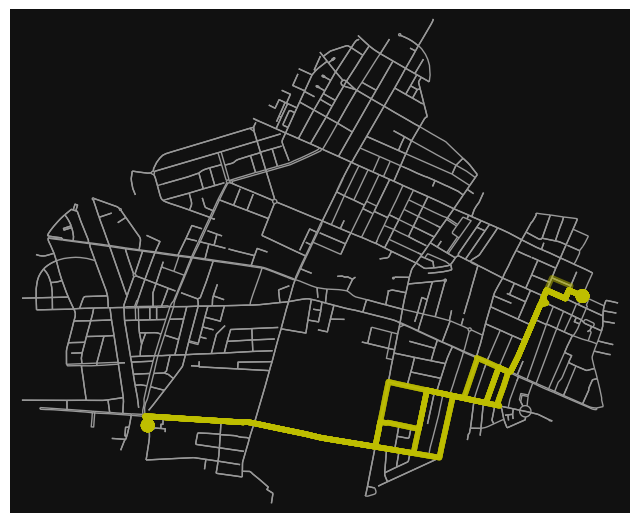

In [47]:
routes = ox.k_shortest_paths(G_fred, orig, dest, k=20, weight="length")
fig, ax = ox.plot_graph_routes(G_fred, list(routes), route_colors="y", route_linewidth=4, node_size=0)

### Imputing travel speeds and times

The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [48]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G_fred)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [49]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

length  speed_kph  travel_time
highway                                                         
['living_street', 'residential']    81.5       50.0          5.9
['unclassified', 'residential']    246.5       40.0         22.2
living_street                      100.7       36.2         10.0
residential                        101.0       47.3          7.7
tertiary                            87.7       49.6          6.4
tertiary_link                        6.5       50.0          0.5
unclassified                        41.3       50.0          3.0

In [50]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 30, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [51]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

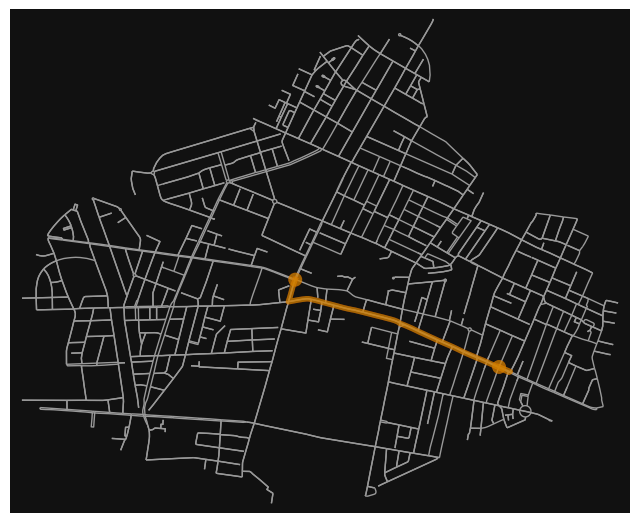

In [52]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [53]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 1808 meters and takes 130 seconds.
Route 2 is 1808 meters and takes 130 seconds.


The yellow route minimizes travel time, and is thus longer but faster than the red route.

For more examples of travel time, see the [isochrones example](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb).

For more examples of routing, including using elevation as an impedance, see the [elevations example](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/12-node-elevations-edge-grades.ipynb).

## 2.6 Saving networks to disk

For more examples of saving and loading networks to/from disk, see [this notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/05-save-load-networks.ipynb).

In [54]:
# save street network as GeoPackage 
ox.save_graph_geopackage(G_fred, filepath="data/network.gpkg")

In [55]:
# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G_fred, filepath="data/network.graphml")

## 2.7 Custom filters and other infrastructure types

Use custom filters to fine-tune your network. OSMnx uses `network_type` presets to query for streets that allow walking, biking, driving, etc. You can override this by passing a `custom_filter` to specify specific OSM ways you want in your graph.

34 motorway


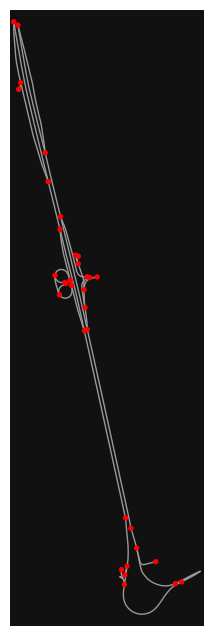

11 primary


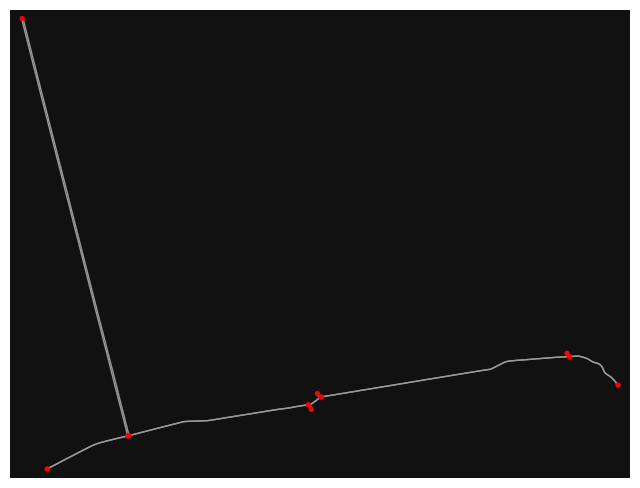

45 motorway + primary


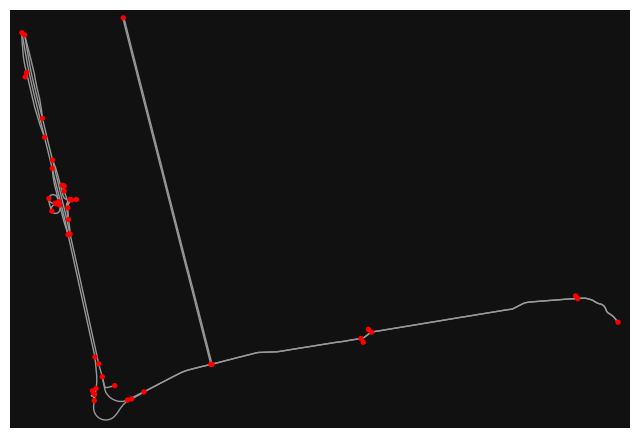

In [56]:
place = {"city": "Berkeley", "state": "California"}

# only get motorway ways
cf = '["highway"~"motorway"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "motorway")
ox.plot_graph(G, node_color="r");

# only get primary ways
cf = '["highway"~"primary"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "primary")
ox.plot_graph(G, node_color="r");

# use the pipe (|) as 'or' operator
cf = '["highway"~"motorway|primary"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "motorway + primary")
ox.plot_graph(G, node_color="r");

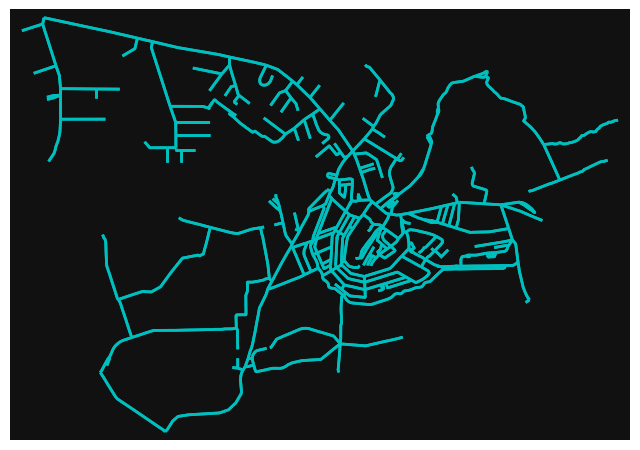

In [57]:
# network of the canals of amsterdam
place = "Amsterdam, Netherlands"
G = ox.graph_from_place(place, custom_filter='["waterway"~"canal"]')
ox.plot_graph(G, edge_color="c", edge_linewidth=2, node_size=0);

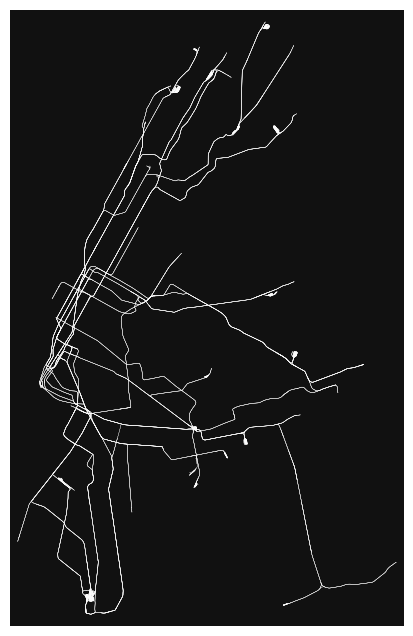

In [58]:
# get NY subway rail network
# note this is rail *infrastructure* and thus includes crossovers, sidings, spurs, yards, etc
# for station-based rail network, you should download a station adjacency matrix elsewhere
ox.settings.useful_tags_way += ["railway"]
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2);

# 3. pyrosm

OSMnx is great for smaller areas, but not efficient enough if you want to get e.g. a street network for an entire country or region. There are many other, faster ways of accessing OSM data, one of them is [pyrosm](https://pyrosm.readthedocs.io/en/latest/basics.html#read-street-networks). The pyrosm library is still fairly new and might have some bugs, but it is much more efficient than OSMnx and also allows for more [custom filters](https://pyrosm.readthedocs.io/en/latest/custom_filter.html).

In [59]:
from pyrosm import OSM
from pyrosm import get_data
fp = get_data("copenhagen")
# Initialize the OSM parser object
osm = OSM(fp)

In [60]:
# Read POIs such as amenities and shops
# =====================================

# By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
# Here, let's read only "amenity" and "shop" by applying a custom filter that
# overrides the default filtering mechanism
custom_filter = {'amenity': True, "shop": True}
pois = osm.get_pois(custom_filter=custom_filter)

# Gather info about POI type (combines the tag info from "amenity" and "shop")
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/pyrosm/pois.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gdf = prepare_geodataframe(
/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


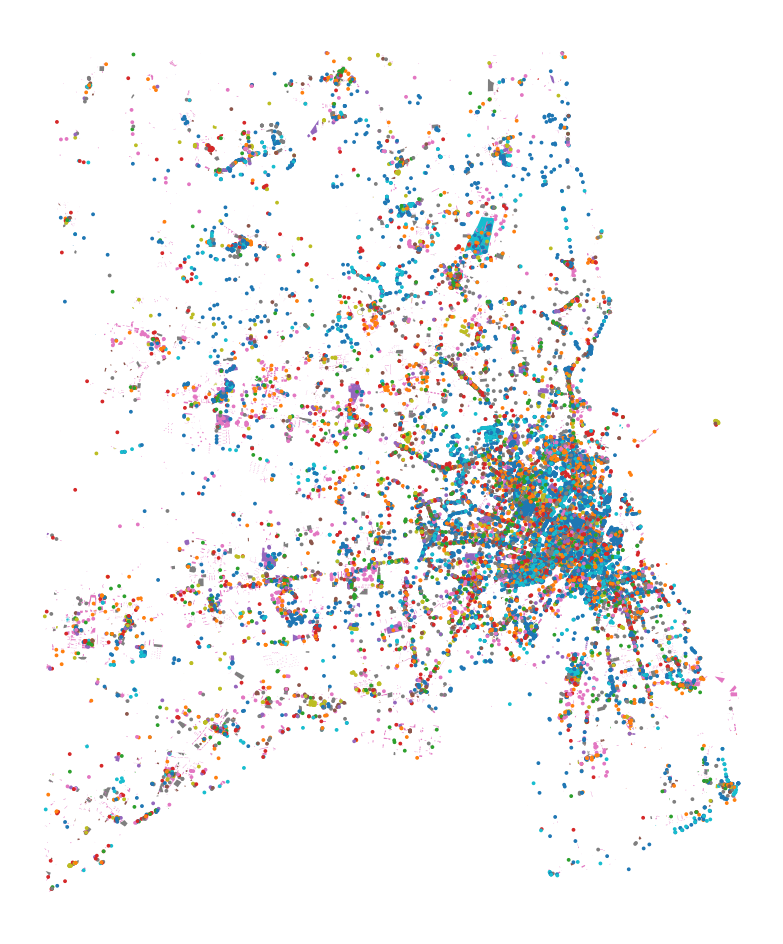

In [61]:
# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=False)
ax.axis("off");

In [62]:
# Test reading all transit related data (bus, trains, trams, metro etc.)
# Exclude nodes (not keeping stops, etc.)
routes = ["bus", "ferry", "railway", "subway", "train", "tram", "trolleybus"]
rails = ["tramway", "light_rail", "rail", "subway", "tram"]
bus = ['yes']
transit = osm.get_data_by_custom_criteria(custom_filter={
                                        'route': routes,
                                        'railway': rails,
                                        'bus': bus,
                                        'public_transport': True},
                                        # Keep data matching the criteria above
                                        filter_type="keep",
                                        # Do not keep nodes (point data)    
                                        keep_nodes=False, 
                                        keep_ways=True, 
                                        keep_relations=True)

/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/pyrosm/user_defined.py:59: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gdf = prepare_geodataframe(
/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


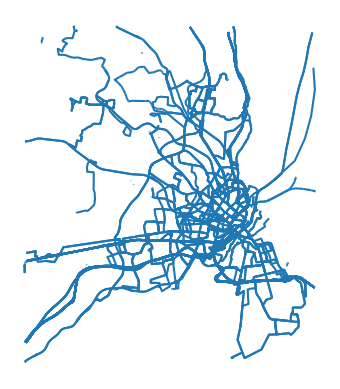

In [63]:
ax = transit.plot()
ax.axis("off");

**For a small performance comparison, compare the execution times of the two cells using respectively pyrosm and OSMnx:**

In [64]:
custom_filter = {'amenity': True, "shop": True}
pois = osm.get_pois(custom_filter=custom_filter)

/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/pyrosm/pois.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gdf = prepare_geodataframe(
/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [65]:
# using the bbox from the pois from pyrosm to replicate extent
west, south, east, nort = pois.unary_union.bounds

In [66]:
tags = {"shop": True, "amenity": True}
pois_osmnx = ox.geometries_from_bbox(north=north, south=south, west=west, east=east, tags=tags)

When testing this notebook, the OSMnx cell took >3 minutes to run, while pyrosm was done in ~4 seconds. Much of the performance benefit from pyrosm comes from the fact that it relies on already-downloaded pbf files with the OSM data.